In [1]:
import sympy as sy
from scipy.optimize import fsolve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy as sp
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import pacf as pacf_func
from statsmodels.graphics.tsaplots import acf as acf_func
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as tsa

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima import model_selection

plt.style.use('ggplot')
import tseries_func as tf

import warnings
warnings.filterwarnings('ignore')

# <font face="gotham" color="purple"> Lag Operator

Lag operator is a type of linear operator especially convenient in time series analysis, it has all properties that a linear operator should have.

Consider an infinite time series $\{y_t\}^{\infty}_{t=-\infty}$, we operate with one lag is denoted as

$$
Ly_t = y_{t-1}
$$

Lag twice or three times

$$
L^2y_t = y_{t-2},\qquad L^3y_t = y_{t-3}
$$

Or a polynomial lag operation 

$$
(1- 3L)(2+4L)(1+2L)y_t
$$

It would be easier to demonstrate with SymPy's algebraic capacity:

In [2]:
L = sy.symbols('L')
poly = (1-3*L)*(2+4*L)*(1+2*L)
poly.expand()

-24*L**3 - 16*L**2 + 2*L + 2

Operate on $y_t$

$$
(- 24 L^{3} - 16 L^{2} + 2 L + 2)y_t = -24y_{t-3}-16y_{t-2}+2y_{t-1}+2y_t
$$

# <font face="gotham" color="purple"> $1st$-Order Difference Equations

Start with 

$$
y_t = \phi y_{t-1}+u_t 
$$

Use lag operator and rearrange
$$
y_t-\phi L y_t = u_t\qquad\longrightarrow\qquad(1-\phi L)y_t = u_t
$$

That mean it must be an inverse of $(1-\phi L)$ which achieves
\begin{align}
(1-\phi L)^{-1}(1-\phi L)y_t&=(1-\phi L)^{-1}u_t\\
y_t&=(1-\phi L )^{-1}u_t\tag{1}\label{1}
\end{align}

How do we find out what $(1-\phi L)^{-1}$ is?

Fortunately, we have encountered this type of series in high school, $(1-\phi L)^{-1}$ can be expanded into an infinite geometric series

$$
\frac{1}{1-\phi L} = 1 + \phi L + \phi^2L^2 + \phi^3L^3 + \cdots =\sum_{i=0}^\infty (\phi L)^i
$$

Rewrite equation $(1)$

$$
y_t = (1 + \phi  L + \phi^2L^2 + \phi ^3L^3 + \cdots)u_t = u_t +\phi u_{t-1}+\phi ^2u_{t-2} + \phi ^3u_{t-3}+\cdots \tag{2}\label{2}
$$

However, though we start from $y_t = \phi y_{t-1}+u_t $ and derived $(2)$, they are not essential consistent. 

Because recall the solution of the $1st$ order difference equation by recursive substitution

$$
y_t = \phi ^t y_0 + \phi ^{t-1}u_{1} +  \phi ^{t-2}u_{2} +\phi ^{t-3}u_{3} + ... + \phi u_{t-1} + u_t\tag{3}\label{3}
$$

Obviously, if you substract $(3)$ from $(2)$, it doesn't get a $0$.

The the leftover infinite series has high powers on $t$, they converge to $0$ on condition that $|\phi|<1$, therefore the only missing term is $\phi ^ty_0$. 

But we can still that the equation $(1)$ holds
\begin{align}
y_t &= \phi^ty_0 + (1-\phi L)^{-1}u_t\\
(1-\phi L)y_t &= (1-\phi L)\phi^ty_0 + (1-\phi L)(1-\phi L)^{-1}u_t\\
& = \phi^ty_0 -\phi\phi^{t-1}y_0 + u_t\\
&=u_t
\end{align}
We proved $y_t=(1-\phi L)^{-1}u_t $, here we assume that $y_0$ is an _initial condition_ which is a constant, which guarantees $Ly_0 = y_0$.

# <font face="gotham" color="purple"> $2nd$-Order Difference Equations

Consider a $2nd$-order difference equation:

$$
y_t=\phi_1y_{t-1}+\phi_2y_{t-2}+u_t \tag{4}\label{4}
$$

In lag operator form

$$
(1-\phi_1L-\phi_2L^2)y_t=u_t
$$

The polynomial on the LHS can be factored

$$
1-\phi_1L-\phi_2L^2 = (1-\lambda_1 L)(1-\lambda_2 L) = 1-(\lambda_1+\lambda_2) L + \lambda_1\lambda_2 L^2
$$

The parameters of polynomial can be pinned down by a system of nonlinear equations
\begin{align}
\lambda_1+\lambda_2 &= \phi_1\\
\lambda_1\lambda_2&=-\phi_2
\end{align}

Assume the model is
$$
y_t=0.9y_{t-1}+0.3y_{t-2}+u_t
$$

Solve the system of nonlinear equations with ```fsolve```

In [3]:
def func(lamda):
    lamda1, lamda2 = lamda[0], lamda[1]
    F = np.empty(2)
    F[0] = lamda1+lamda2-.9
    F[1] = lamda1*lamda2+0.3
    return F
lamda_guess = np.array([0, 0]) # [1, 1] is initial value
lamda1, lamda2 = fsolve(func, lamda_guess)
print('lambda1 : {:.4f}, lambda2： {:.4f}'.format(lamda1, lamda2))

lambda1 : 1.1589, lambda2： -0.2589


$$
1-0.9L-0.3L^2 = (1-\underbrace{1.1589}_{\lambda_1} L)(1+\underbrace{0.2589}_{-\lambda_2} L)
$$

As a reference, we post another solution from $2nd$ order difference equation, more details are in later sections

In [4]:
lamda1 = (.9+np.sqrt(.9**2+4*.3))/2
lamda2 = (.9-np.sqrt(.9**2+4*.3))/2
print('lambda1 and lambda2 are {0:.3f} and {1:.3f} respectively.'.format(lamda1, lamda2))

lambda1 and lambda2 are 1.159 and -0.259 respectively.


The $\lambda$'s here are actually the eigenvalues of the linear system if we rewrite the system into a matrix form. But don't worry about the details yet, we will demonstrate the gory details in this chapter later.

The system $(4)$ will be stable only when both eigenvalues, $\lambda_1$ and $\lambda_2$'s modulus less than $1$, geometrically they must lie inside a unit circle, if lie on the unit circle or outside, the system is explosive.

In [5]:
ar_params = np.array([1, -0.8, 0.35]) # alwasy specify zero lag as 1
ma_params = np.array([1]) # alwasy specify zero lag as 1
ar2 = ArmaProcess(ar_params, ma_params) # the Class requires AR and MA's parameters
ar2_sim = ar2.generate_sample(nsample=100)  
ar2_sim = pd.DataFrame(ar2_sim, columns = ['AR(2)']) 
ar2_acf = acf_func(ar2_sim.values, fft=False, nlags = 50)  # return the numerical ACF 

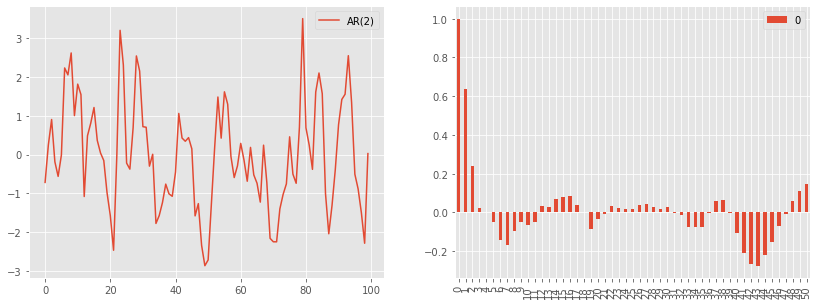

In [6]:
fig, ax = plt.subplots(figsize = (14, 5), nrows=1, ncols=2)
ar2_sim.plot(ax = ax[0])
pd.DataFrame(ar2_acf).plot.bar(ax=ax[1], label='ACF')
plt.show()

# <font face="gotham" color="purple"> Solving $1st$ Order Difference Equations </font>

Now we turn to difference equations in more details, which are horses of all dynamic system researches, including time series analysis.

Difference equations are commonly solved by _recursive substitution_, consider the $1st$ difference equation below, where $u_t$ is a white noise process

$$
y_t = \phi y_{t-1} + u_t \tag{5}\label{5}
$$

and shift one period backward

$$
y_{t-1} =\phi  y_{t-2} + u_{t-1}
$$

Substitute back to the original equation $(1)$

$$
y_t = \phi (\phi y_{t-2} + u_{t-1}) + u_t = \phi^2y_{t-2} + \phi u_{t-1} +u_t
$$

then substitute $y_{t-2}$, 

$$
y_t = \phi^2(\phi y_{t-3} + u_{t-2})  + \phi u_{t-1}= \phi^3y_{t-3}+\phi^2u_{t-2}+\phi u_{t-1}+u_t
$$

continue the recursive substitution, the solution will take form as an infinite series

$$
y_t = \phi^t y_0 + \phi^{t-1}u_{1} +  \phi^{t-2}u_{2} + \phi^{t-3}u_{3} + ... + \phi u_{t-1} + u_t
$$

## <font face="gotham" color="purple"> Dynamic Multiplier

The dynamic multiplier is a partial derivative toward $u_i,\ i \in (1,2,.., t)$, e.g. dynamic multiplier of $u_1$

$$
\frac{\partial y_t}{\partial u_1} = \phi^{t-1}
$$

The value of $\phi$ characterizes the pattern of the difference equation.

The charts below shows how the parameter $\phi$ determines the system.

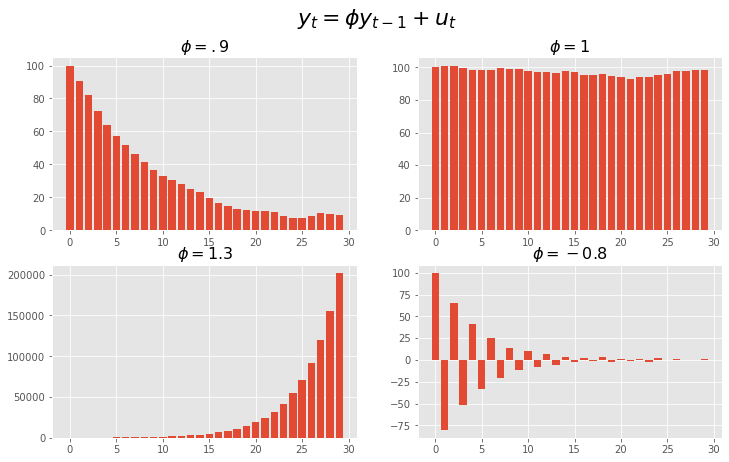

In [7]:
y = np.zeros(30)
y[0] = 100

ax_pos = [221, 222, 223, 224]
fig = plt.figure(figsize = (12, 7))
tt = ['$\phi=.9$', '$\phi=1$', '$\phi=1.3$', '$\phi=-0.8$']
phi = [.9, 1, 1.3, -.8]

for j in range(4):
    ax = fig.add_subplot(ax_pos[j])
    for i in range(1, 30):
        u = np.random.randn()
        y[i] = phi[j]*y[i-1]+u
    ax.bar(np.arange(len(y)),y)
    ax.set_title(tt[j], size=16)
plt.suptitle(r'$y_t=\phi y_{t-1}+u_t$', size = 22)
plt.show()

As long as $-1<\phi<1$, the system will be stable, otherwise explosive.

# <font face="gotham" color="purple"> Solving $k$-th Order Difference Equations

Define the $k$-vector $\pmb{y}_t$ by

$$
\pmb{y}_t=
\left[
\begin{matrix}
y_t\\
y_{t-1}\\
y_{t-2}\\
\vdots\\
y_{t-k+1}
\end{matrix}
\right]
$$

Define the $k\times k$ matrix $\pmb{F}$ by

$$
\pmb{F}=
\left[
\begin{matrix}
\phi_1 & \phi_2 & \phi_3 &\cdots &\phi_{k-1} & \phi_k\\
1 & 0 & 0 &\cdots &0 & 0\\
0 & 1 & 0 &\cdots &0 & 0\\
\vdots  &\vdots & \vdots& \ddots &\vdots & \vdots\\
0 & 0 & 0 &\cdots & 1 & 0
\end{matrix}
\right]
$$

Last, define $k$-vector $\pmb{u}_t$ by

$$
\pmb{u_t}=
\left[
\begin{matrix}
u_t\\
0\\
0\\
\vdots\\
0
\end{matrix}
\right]
$$

Thus linear system in matrix form is 

$$
\pmb{y}_t = \pmb{F}\pmb{y}_{t-1}+\pmb{u}_t  
$$

or explicitly

$$
\left[
\begin{matrix}
y_t\\
y_{t-1}\\
y_{t-2}\\
\vdots\\
y_{t-k+1}
\end{matrix}
\right]=
\left[
\begin{matrix}
\phi_1 & \phi_2 & \phi_3 &\cdots &\phi_{k-1} &\phi_k\\
1 & 0 & 0 &\cdots &0 & 0\\
0 & 1 & 0 &\cdots &0 & 0\\
\vdots  &\vdots & \vdots& \ddots &\vdots & \vdots\\
0 & 0 & 0 &\cdots & 1 & 0
\end{matrix}
\right]
\left[
\begin{matrix}
y_{t-1}\\
y_{t-2}\\
y_{t-3}\\
\vdots\\
y_{t-k}
\end{matrix}
\right]
+
\left[
\begin{matrix}
u_t\\
0\\
0\\
\vdots\\
0
\end{matrix}
\right]
$$

The recursive substitutions of matrix form give us a general expression

$$
\pmb{y}_t = \pmb{F}^t \pmb{y}_0 + \pmb{F}^{t-1}\pmb{u}_{1} + \pmb{F}^{t-2}\pmb{u}_{2} + \pmb{F}^{t-3}\pmb{u}_{3} + ... + \pmb{F}\pmb{u}_{t-1} + \pmb{u}_t
$$

$$
\begin{aligned}
\left[\begin{array}{c}
y_{t} \\
y_{t-1} \\
y_{t-2} \\
\vdots \\
y_{t-k+1}
\end{array}\right]=\pmb{F}^{t}\left[\begin{array}{c}
y_{0} \\
y_{-1} \\
y_{-2} \\
\vdots \\
y_{-k+1}
\end{array}\right]+\pmb{F}^{t-1}\left[\begin{array}{c}
u_{1} \\
0 \\
0 \\
\vdots \\
0
\end{array}\right]+\pmb{F}^{t-2}\left[\begin{array}{c}
u_{2} \\
0 \\
0 \\
\vdots \\
0
\end{array}\right]
+\pmb{F}^{t-3}\left[\begin{array}{c}
u_{3} \\
0 \\
0 \\
\vdots \\
0
\end{array}\right]+\cdots+\pmb{F}\left[\begin{array}{c}
u_{t-1} \\
0 \\
0 \\
\vdots \\
0
\end{array}\right]
\end{aligned} 
+
\left[\begin{array}{c}
u_{t} \\
0 \\
0 \\
\vdots \\
0
\end{array}\right]\tag{6}\label{6}
$$

## <font face="gotham" color="purple"> Dynamic Multiplier

If $\pmb{F}$ has $k$ distinct eigenvalues, it is possible to be diagonalized, such that

$$
\pmb{F} = \pmb{P\Lambda P}^{-1}
$$

where $\pmb{P}$ holds all the distinct eigenvectors, whereas all the distinct eigenvalues stay on the principal diagonal of $\pmb{\lambda}$.

The eigenvalue can characterize the dynamic multiplier as we have seen for the $1st$-order difference equation. For instance, $\pmb{F}^3$ is decomposed as

$$
\pmb{F}^3  =  \pmb{P\Lambda P}^{-1}  \pmb{P\Lambda P}^{-1}  \pmb{P\Lambda P}^{-1} = \pmb{P\Lambda }  \pmb{\Lambda }  \pmb{\Lambda P}^{-1} =\pmb{P}  \pmb{\Lambda }^3  \pmb{P}^{-1} 
$$

where 

$$
\pmb{\Lambda }^3  = \left[\begin{array}{ccccc}
\lambda_{1}^{3} & 0 & 0 & \cdots & 0 \\
0 & \lambda_{2}^{3} & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \lambda_{k}^{3}
\end{array}\right]
$$

Therefore in general, 
$$
\pmb{F}^t =\pmb{P}  \pmb{\Lambda }^t  \pmb{P}^{-1}
$$

Denote the $(i, j)$ element of $\pmb{F}^t$ as $f^{(t)}_{ij}$, for instance the $(4, 5)$ element of $\pmb{F}^{t-1}$ is $f^{(t-1)}_{45}$. The first row of system $(6)$ is

$$
y_t = f^{(t)}_{11}y_0+ f^{(t)}_{12}y_{-1} + f^{(t)}_{13}y_{-2} + \cdots + f^{(t)}_{1k}y_{-k-1} + f^{(t-1)}_{11}u_1 +f^{(t-2)}_{11}u_2 +...+f^{1}_{11}u_{t-1}+u_{t}
$$

To generalize the time span

$$
y_{t+i} = f^{(i)}_{11}y_t+ f^{(i)}_{12}y_{t-1} + f^{(i)}_{13}y_{t-2} + \cdots + f^{(i)}_{1k}y_{t-k-1} + f^{(i-1)}_{11}u_t +f^{(i-2)}_{11}u_{t+2} +...+f^{1}_{11}u_{t+i-1}+u_{t+i}
$$

The dynamic multiplier is 

$$
\frac{\partial y_{t+i}}{\partial u_t} = f^{(i-1)}_{11}
$$

We can show that dynamic multiplier is a linear combination of the power of eigenvalues.

$$
\frac{\partial y_{t+i}}{\partial u_t} = f^{(i-1)}_{11} = c_1 \lambda_1^{i-1}+c_2 \lambda_2^{i-1}+ \cdots + c_p \lambda_p^{i-1}
$$

## <font face="gotham" color="purple"> Linear Combination of Eigenvalues of $\pmb{F}$

If we denote $t_{ij}$ and $t^{ij}$ the $(i, j)$ element of $\pmb{P}$ and $\pmb{P}^{-1}$ respectively. $\pmb{F}^{i-1}$ can be explicitly written as

$$
\pmb{F}^{i-1}=\left[\begin{array}{cccc}
t_{11} & t_{12} & \cdots & t_{1 k} \\
t_{21} & t_{22} & \cdots & t_{2 k} \\
\vdots & \vdots & \ddots & \vdots \\
t_{k 1} & t_{k 2} & \cdots & t_{kk}
\end{array}\right]\left[\begin{array}{ccccc}
\lambda_{1}^{i-1} & 0 & 0 & \cdots & 0 \\
0 & \lambda_{2}^{i-1} & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \lambda_{k}^{i-1}
\end{array}\right]\left[\begin{array}{ccccc}
t^{11} & t^{12} & \cdots & t^{1 k} \\
t^{21} & t^{22} & \cdots & t^{2 k} \\
\vdots & \vdots & \ddots & \vdots \\
t^{k 1} & t^{k 2} & \cdots & t^{k k}
\end{array}\right]
$$

The $(1, 1)$ element of $\pmb{F}^{i-1}$ is 

\begin{align}
f^{(i-1)}_{11}&=\left(t_{11} t^{11}\right) \lambda_{1}^{i-1}+\left(t_{12} t^{21}\right) \lambda_{2}^{i-1}+\cdots+\left(t_{1 k} t^{k 1}\right) \lambda_{k}^{i-1}\\&=c_{1} \lambda_{1}^{i-1}+c_{2} \lambda_{2}^{i-1}+\cdots+c_{p} \lambda_{k}^{i-1}
\end{align}

where $c_j = t_{1j}t^{j1},\ j \in (1,...,k)$.

Fortunately, not hard to notice that

$$
c_1+c_2+\cdots+c_k = t_{11}t^{11}+t_{12}t^{21}+\cdots + t_{1k}t^{k1}=1
$$

is the $(1,1)$ element of $\pmb{P}\pmb{P}^{-1}$ which also happen to be $1$.

We have completed the proof that the dynamic multiplier is the linear combination of eigenvalues

$$
\frac{\partial y_{t+i}}{\partial u_t} = f^{(i-1)}_{11} = c_1 \lambda_1^{i-1}+c_2 \lambda_2^{i-1}+ \cdots + c_p \lambda_p^{i-1}
$$

## <font face="gotham" color="purple"> Solution of $2nd$-Order Difference Equation

For a $2nd$ order difference equation
$$
y_t = \phi_1 y_{t-1} +\phi_2 y_{t-2} u_t 
$$
The eigenvalues of $\pmb{F}$ is found by solving characteristic equation $|\pmb{F}-\lambda \pmb{I}_p|=0$, if you don't know what it means, click <a href='https://nbviewer.org/github/WeijieChen-MacroAnalyst/Linear_Algebra_With_Python/blob/master/Chapter%2012%20-%20Eigenvalues%20and%20Eigenvectors.ipynb'>here</a>, explicitly

$$
\left|
\left[
\begin{matrix}
\phi_1 & \phi_2\\
1 & 0
\end{matrix}
\right]-
\lambda\left[
\begin{matrix}
1 & 0\\
0 & 1
\end{matrix}
\right]
\right|=0
$$

or in polynomial form

$$
\left|
\begin{matrix}
\phi_1-\lambda & \phi_2\\
1 & -\lambda
\end{matrix}
\right|=
\lambda^2-\phi_1\lambda-\phi_2=0
$$

Now recall a high school formula 

$$
x=\frac{-b \pm \sqrt{b^{2}+4 a c}}{2 a}
$$

We obtain roots by plug-in

$$
\lambda_1=\frac{\phi_1+\sqrt{\phi_1^2+4\phi_2}}{2}\\
\lambda_2=\frac{\phi_1-\sqrt{\phi_1^2+4\phi_2}}{2}
$$

As an example, consider a second-order difference equation
$$
y_t=0.9y_{t-1}+0.3y_{t-2}+u_t
$$

Solve for the eigenvalues via formulae above 

In [8]:
lamda1 = (.9+np.sqrt(.9**2+4*.3))/2
lamda2 = (.9-np.sqrt(.9**2+4*.3))/2
print('lambda1 and lambda2 are {0:.3f} and {1:.3f} respectively.'.format(lamda1, lamda2))

lambda1 and lambda2 are 1.159 and -0.259 respectively.


We actually used the same example from lag operator's section, the eigenvalues are the same as well.

The weight of powre of eigenvalues 

$$
c_1 = \frac{\lambda_1}{\lambda_1 +|\lambda_2|}\\
c_2 = \frac{|\lambda_2|}{\lambda_1 +|\lambda_2|}
$$

In [9]:
c1 = lamda1/(lamda1+np.abs(lamda2))
c2 = np.abs(lamda2)/(lamda1+np.abs(lamda2))
print('c1 and c2 are {0:.3f} and {1:.3f} respectively.'.format(c1, c2))

c1 and c2 are 0.817 and 0.183 respectively.


The dynamic multiplier

$$
\frac{\partial y_{t+i}}{\partial u_t}= c_1 \lambda_1^{i-1}+c_2 \lambda_2^{i-1} 
$$

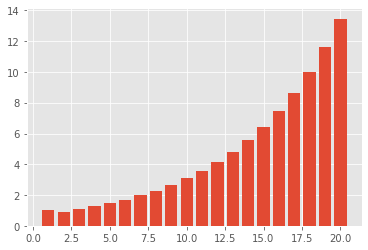

In [10]:
i = np.arange(1, 21)
pypu = c1*lamda1**(i-1)+c2*lamda2**(i-1)
plt.bar(np.arange(len(pypu))+1, pypu)
plt.show()

This is an explosive system, since one eigenvalue is larger than $1$. However let's take a look at the graph below, demonstrating different eigenvalues and corresponding behaviors of the system.They are plotted as functions of $i$: $f(i)= c_1 \lambda_1^{i-1}+c_2 \lambda_2^{i-1}$

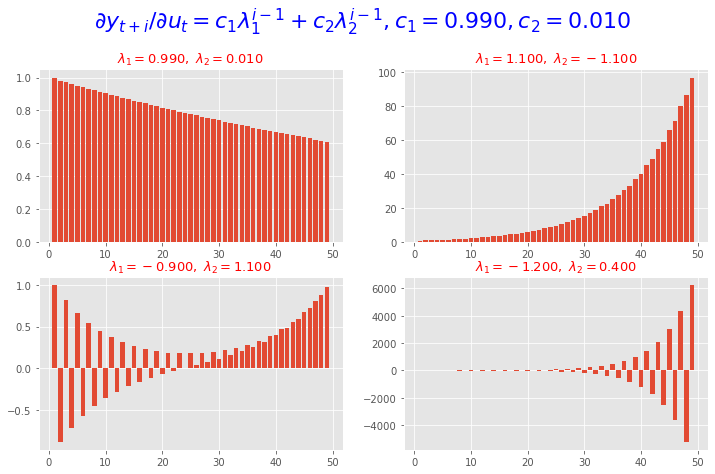

In [11]:
i = np.arange(1, 50)

lamda1 = [.99, 1.1, -.9, -1.2]
lamda2 = [.01, -1.1, 1.1, .4]
c1 = .99
c2 = 1 - c1

fig = plt.figure(figsize = (12, 7))
ax_pos = [221, 222, 223, 224]

for j in range(4):
    ax = fig.add_subplot(ax_pos[j])
    pypu1 = c1*lamda1[j]**(i-1)+c2*lamda2[j]**(i-1)
    ax.bar(np.arange(len(pypu1))+1, pypu1)
    tt = '$\lambda_1 = %.3f,\ \lambda_2 = %.3f$'%(lamda1[j], lamda2[j])
    ax.set_title(tt, size = 13, color = 'r')
plt.suptitle('$\partial y_{t+i}/\partial u_t = c_1 \lambda_1^{i-1}+c_2 \lambda_2^{i-1}, c_1 = %.3f, c_2 = %.3f$'%(c1, c2), size = 22, color = 'b', x = .5, y = 1.005)
plt.show()

## <font face="gotham" color="purple"> The Dynamic Multiplier of $3rd$- and $4th$-Order Difference Equation

Suppose the dynamic multiplier is $f(i)= c_1 \lambda_1^{i-1}+c_2 \lambda_2^{i-1}+c_3 \lambda_3^{i-1}$

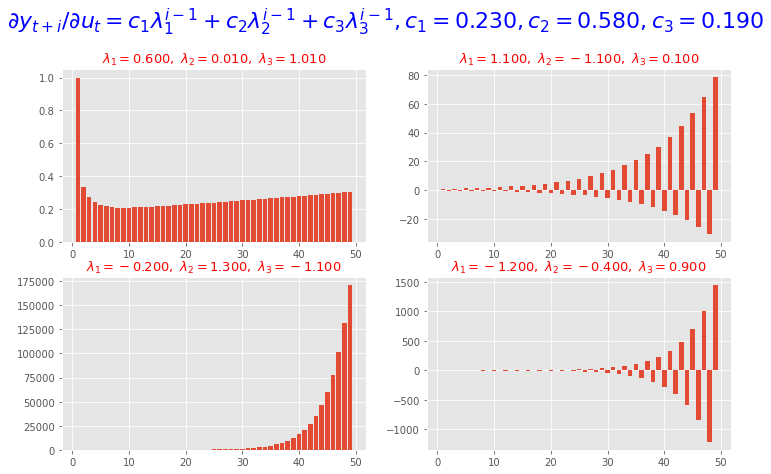

In [12]:
i = np.arange(1, 50)

lambda1 = [.6, 1.1, -.2, -1.2]
lambda2 = [.01, -1.1, 1.3, -.4]
lambda3 = [1.01, 0.1, -1.1, .9]

c1 = .23
c2 = .58
c3 = 1 - c1 - c2

fig = plt.figure(figsize = (12, 7))
ax_pos = [221, 222, 223, 224]

for j in range(4):
    ax = fig.add_subplot(ax_pos[j])
    pypu1 = c1*lambda1[j]**(i-1)+c2*lambda2[j]**(i-1)+c3*lambda3[j]**(i-1)
    ax.bar(np.arange(len(pypu1))+1, pypu1)
    tt = '$\lambda_1 = %.3f,\ \lambda_2 = %.3f,\ \lambda_3 = %.3f$'%(lambda1[j], lambda2[j], lambda3[j])
    ax.set_title(tt, size = 13, color = 'r')
plt.suptitle('$\partial y_{t+i}/\partial u_t = c_1 \lambda_1^{i-1}+c_2 \lambda_2^{i-1}+c_3 \lambda_3^{i-1}, c_1 = %.3f, c_2 = %.3f, c_3 = %.3f$'%(c1, c2, c3), 
             size = 22, color = 'b', x = .5, y = 1.005)
plt.show()